### NOTEBOOK CONTENTS:

1. Movie Latent Vectors
2. User Latent Vectors
3. Movie Community Detection and basic Exploratory Data Analysis
4. Input JSON for FLOWER PLOT preparation


# Basic Statistics

<img src="https://drive.google.com/uc?export=view&id=1FLsndvwBUC3XdEYExFTWgRcNRfm0G-qA"></img>

# Idea of Analysis

1) Start from user-movie ratings data (which doesn't have any information about movies or user meta-data).

2) Generate user and movie embeddings using NCF.

3) Gerate a user network and a movie network using the embeddings.

4) Discover communities of users as well as movies.

5) Now PLUG IN the meta data to find "insights" i.e. the driving factors of movie viewership and user consumption.

<img src="https://drive.google.com/uc?export=view&id=1UI9v6xsoXef60lgCCgDZVDphn4dUfong"></img>

### SUMMARY OF MAJOR RESULTS:

Distribution of average_movie_ratings and avg_votes contrast nicely over various movie communities

In [2]:
## imports for NCF
!pip install torch==1.8.0
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
import torch
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()
from IPython.core.debugger import set_trace #debugging
#fastai library imports: https://github.com/fastai/fastai
from fastai.learner import *
#from fastai.column_data import *
from fastai.tabular.all import *
from fastai.tabular import *
import pandas as pd

## imports for Community Detection
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from sklearn import metrics
import networkx as nx
import community as community_louvain
import scipy
from collections import defaultdict

## 1. Generating user and movie embeddings

In [6]:
## data loading
ratings = pd.read_csv(f'/content/gdrive/MyDrive/movies_big/emb/ratings.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [10]:
print("No of unique user-movie rating rows: %s"%(ratings.shape[0]))
mini_ratings = ratings.sample(frac=0.01).reset_index(drop=True)
ratings = mini_ratings.copy()

No of unique user-movie rating rows: 26024289


## 1.1 Neural Collaborative Filtering 

CODE: https://docs.fast.ai/collab.html 

Using the Fast.ai implementation

In [ ]:
#There were some in issues in recovering the movie and user ids so making the changes in the source code to handle them.
class TabularCollab(TabularPandas):
    "Instance of `TabularPandas` suitable for collaborative filtering (with no continuous variable)"
    with_cont=False

#export
class CollabDataLoaders(DataLoaders):
    "Base `DataLoaders` for collaborative filtering."
    @delegates(DataLoaders.from_dblock)
    @classmethod
    def from_df(cls, ratings, valid_pct=0.2, user_name=None, item_name=None, rating_name=None, seed=None, path='.', **kwargs):
        "Create a `DataLoaders` suitable for collaborative filtering from `ratings`."
        user_name   = ifnone(user_name,   ratings.columns[0])
        item_name   = ifnone(item_name,   ratings.columns[1])
        rating_name = ifnone(rating_name, ratings.columns[2])
        cat_names = [user_name,item_name]
        splits = RandomSplitter(valid_pct=valid_pct, seed=seed)(range_of(ratings))
        to = TabularCollab(ratings, [Categorify], cat_names, y_names=[rating_name], y_block=TransformBlock(), splits=splits)
        return to.dataloaders(path=path, **kwargs)

    @classmethod
    def from_csv(cls, csv, **kwargs):
        "Create a `DataLoaders` suitable for collaborative filtering from `csv`."
        return cls.from_df(pd.read_csv(csv), **kwargs)

#export
class EmbeddingDotBias(Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [Embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, x):
        users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

    @classmethod
    def from_classes(cls, n_factors, classes, user=None, item=None, y_range=None):
        "Build a model with `n_factors` by inferring `n_users` and  `n_items` from `classes`"
        if user is None: user = list(classes.keys())[0]
        if item is None: item = list(classes.keys())[1]
        res = cls(n_factors, len(classes[user]), len(classes[item]), y_range=y_range)
        res.classes,res.user,res.item = classes,user,item
        return res

    def _get_idx(self, arr, is_item=True):
        "Fetch item or user (based on `is_item`) for all in `arr`"
        assert hasattr(self, 'classes'), "Build your model with `EmbeddingDotBias.from_classes` to use this functionality."
        classes = self.classes[self.item] if is_item else self.classes[self.user]
        c2i = {v:k for k,v in enumerate(classes)}
        try: return tensor([c2i[o] for o in arr])
        except Exception as e:
            print(f"""You're trying to access {'an item' if is_item else 'a user'} that isn't in the training data.
                  If it was in your original data, it may have been split such that it's only in the validation set now.""")

    def bias(self, arr, is_item=True):
        "Bias for item or user (based on `is_item`) for all in `arr`"
        idx = self._get_idx(arr, is_item)
        layer = (self.i_bias if is_item else self.u_bias).eval().cpu()
        return to_detach(layer(idx).squeeze(),gather=False)

    def weight(self, arr, is_item=True):
        "Weight for item or user (based on `is_item`) for all in `arr`"
        idx = self._get_idx(arr, is_item)
        layer = (self.i_weight if is_item else self.u_weight).eval().cpu()
        return to_detach(layer(idx),gather=False)
#export 
class EmbeddingNN(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    @delegates(TabularModel.__init__)
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs=emb_szs, n_cont=0, out_sz=1, layers=layers, **kwargs)
# export
@delegates(Learner.__init__)
def collab_learner(dls, n_factors=50, use_nn=False, emb_szs=None, layers=None, config=None, y_range=None, loss_func=None, **kwargs):
    "Create a Learner for collaborative filtering on `dls`."
    emb_szs = get_emb_sz(dls, ifnone(emb_szs, {}))
    if loss_func is None: loss_func = MSELossFlat()
    if config is None: config = tabular_config()
    if y_range is not None: config['y_range'] = y_range
    if layers is None: layers = [n_factors]
    if use_nn: model = EmbeddingNN(emb_szs=emb_szs, layers=layers, **config)
    else:      model = EmbeddingDotBias.from_classes(n_factors, dls.classes, y_range=y_range)
    return Learner(dls, model, loss_func=loss_func, **kwargs)

CollabDataLoaders.from_csv = delegates(to=CollabDataLoaders.from_df)(CollabDataLoaders.from_csv)

In [ ]:
## function to generate and write the user and movie embeddings learnt from NCF
def generate_user_movie_embeddings_nn(mini_ratings, emb_szs={'user': 512, 'item':512}, out_folder = "/content/gdrive/MyDrive/movies_big/emb"):
    """
    mini_ratings : pd.DataFrame | with columns <userId, movieId, rating>
    emb_szs : dict | A dictionary with keys as 'user', 'item' specifying embedding dimensions
    out_folder : str | path of the folder to dump the emebddings
    """
    dls = CollabDataLoaders.from_df(mini_ratings, bs=64)
    learn = collab_learner(dls, y_range=(0,5),use_nn=True, emb_szs=emb_szs)
    learn.fit_one_cycle(1)  
    try:
        u_mat = to_np(learn.model.embeds[0].weight[1:])
        m_mat = to_np(learn.model.embeds[1].weight[1:]) 
        u_ids = np.array(learn.dls.train_ds.classes['userId'][1:])
        m_ids = np.array(learn.dls.train_ds.classes['movieId'][1:])
        print(u_mat.shape, m_mat.shape, u_ids.shape, m_ids.shape)
        if out_folder:
            with open(out_folder+'/u_mat.pkl','wb') as f:
                pickle.dump(u_mat, f)
            with open(out_folder+'/m_mat.pkl','wb') as f:
                pickle.dump(m_mat, f)
            with open(out_folder+'/u_ids.pkl','wb') as f:
                pickle.dump(u_ids, f)
            with open(out_folder+'/m_ids.pkl','wb') as f:
                pickle.dump(m_ids, f)
    except Exception as e:
        print(e)
        return learn
    return learn

In [12]:
l = generate_user_movie_embeddings_nn(ratings)
with open('/content/gdrive/MyDrive/movies_big/emb'+'/l.pkl','wb') as f:
    pickle.dump(l, f)
ratings.to_csv("/content/gdrive/MyDrive/movies_big/emb/ratings.csv")

## 2. Movie Communities

In [14]:
## Loading the embeddings
f_name = "/content/drive/MyDrive/movies_big/emb"
def load_embeddings(f_name):
    with open(f_name+'/u_mat.pkl','rb') as f:
                u_mat = pickle.load(f)
    with open(f_name+'/m_mat.pkl','rb') as f:
                m_mat = pickle.load(f)
    with open(f_name+'/m_ids.pkl','rb') as f:
                m_ids = pickle.load(f)
    with open(f_name+'/u_ids.pkl','rb') as f:
                u_ids = pickle.load(f)
    return m_mat, m_ids, u_mat, u_ids

m_mat, m_ids, u_mat, u_ids = load_embeddings(f_name)
m_mat.shape, m_ids.shape, u_mat.shape, u_ids.shape
ratings = pd.read_csv(f_name+"/ratings.csv")
#del u_mat, u_ids

### 2.1 Movie Network/Graph creation

Logic:

1) Create an NXN adjacency matrix by taking pairwise cosine similarity of movie embeddings.

2) There will be an edge between two movies if their similarity is above a certain threshold. So, update the weighted adjacency matrix by removing the edges having weight below the threshold.

In [ ]:
def create_weighted_adjacency_mat(mat, thresh):
    """
    Function to filter out below threshold edges
    """
    mat[mat<thresh]=0
    return mat


## Adj matrix creation (fully connected graph)
movie_sim = metrics.pairwise.cosine_similarity(m_mat)

## Filter out unwanted edges and remove the movies which end up with no edges
movie_sim = create_weighted_adjacency_mat(movie_sim, 0.9)
np.fill_diagonal(movie_sim, 0)
r_keep_idxs = ~np.all(movie_sim == 0, axis=1)
c_keep_idxs = ~np.all(movie_sim.T == 0, axis=1)
print("Sanity: ", np.all(r_keep_idxs == c_keep_idxs))
#sum(r_keep_idxs) #13563

## Converting the matrix to sparse matrix to save up on the resources
movie_sim = scipy.sparse.csr_matrix(movie_sim)
movie_sim = movie_sim[r_keep_idxs]
movie_sim = movie_sim.T[c_keep_idxs].T

Sanity:  True


## 2.2 Community Detection : Louvain's algorithm

In [ ]:
# networkx graph creation
G = nx.convert_matrix.from_scipy_sparse_matrix(movie_sim) #G = nx.read_gpickle("/content/drive/MyDrive/movies_big/emb/movies_graph.gpickle")
# dumping the graph
nx.write_gpickle(G, f_name+"/movies_graph.gpickle")
# community detection
partition = community_louvain.best_partition(G, weight='weight')
## Modularity
community_louvain.modularity(partition, G, weight='weight')

0.5244945066692962

In [ ]:
# Community IDs found
np.unique(list(partition.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [ ]:
keep_m_ids = m_ids[r_keep_idxs]

## 2.3 Basic EDA on Movie Communities

Visualize the distributions of 
- Average movie ratings for each of the movie communities (to capture the quality/goodness of the movie)
- Number of votes for each of the movie communities (to capture the popularity of the movie)

In [ ]:
# Some processing needs to be done for fetching the above distributions

## Currently, we have user-movie-rating relationship. We need to find a single rating value for each movie 
## and this can be done by taking the average of all the ratings given to each movie

### Similarly, we need to find the number of times a given movie was rated.


communitites = defaultdict(list)

for key, value in sorted(partition.items()):
    communitites[value].append(keep_m_ids[key])

m_group = ratings.groupby("movieId")
movies_df = pd.DataFrame()
m_list = []
for g in m_group:
    m_list.append(g[0])
movies_df['id'] = m_list
del m_list

movies_df['average_ml_rating'] = m_group['rating'].apply(lambda x: np.mean(list(x))).values
movies_df['n_ratings'] = m_group['userId'].apply(lambda x: len(list(x))).values
movie_community_rating_df = pd.DataFrame({'community':communitites.keys(), 'id':communitites.values()}).explode('id')
movie_community_rating_df = movie_community_rating_df.merge(movies_df, how='left')
movie_community_rating_df = movie_community_rating_df.merge(pd.DataFrame(list(enumerate(keep_m_ids)),columns=['graph_idx', 'id']), how='left')

In [ ]:
movie_community_rating_df.head(1)

,community,id,average_ml_rating,n_ratings,graph_idx
0,5,1,3.888157,66008,0


In [ ]:
movie_community_rating_df.groupby('community').aggregate(np.mean)
# movie_community_rating_df.to_csv('/content/drive/MyDrive/movies_big/emb/m_communities.csv', index=False)

,average_ml_rating,n_ratings
community,,
0,2.675108,72.500000
1,3.225300,248.000000
2,3.436913,41.500000
3,3.658895,376.000461
4,3.769104,2614.793696
5,4.037579,25519.601562
6,3.467889,73.914270
7,3.497291,29.323077
8,2.958559,417.000000


For better contrast and substantial findings, consdering only the communities which more than 100 movies in them. Basically, ignoring the outlier communities.

In [ ]:
movie_community_rating_df['community'].value_counts()

7     4420
12    2957
3     2169
4     2094
6     1773
5      128
11       6
10       4
13       2
2        2
9        2
1        2
8        2
0        2
Name: community, dtype: int64

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be remove

3
4
5
6
7
12


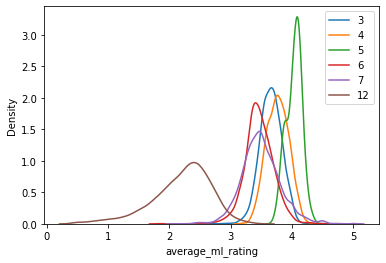

In [ ]:
## Plotting distribution
for g in movie_community_rating_df.groupby('community'):
    com = g[0]
    avg_ratings = g[1]['average_ml_rating']
    n_ratings = g[1]['n_ratings']
    if len(avg_ratings)>100:
        sns.distplot(avg_ratings, hist=False, label=com)
    plt.legend()
    plt.plot()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be remove

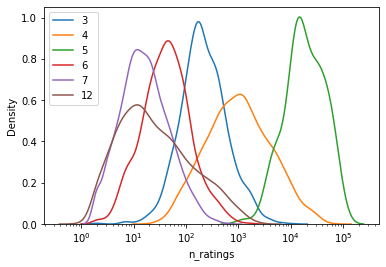

In [ ]:
## Plotting distribution
for g in movie_community_rating_df.groupby('community'):
    com = g[0]
    avg_ratings = g[1]['average_ml_rating']
    n_ratings = g[1]['n_ratings']
    plt.xscale('log')
    if len(avg_ratings)>100:
        sns.distplot(n_ratings, hist=False, label=com)
        plt.plot()
    plt.legend()
    plt.plot()

In [ ]:
movie_community_rating_df[movie_community_rating_df['community']==5]

,community,id,average_ml_rating,n_ratings,graph_idx
0,5,1,3.888157,66008,0
1,5,36,3.931582,23751,5
2,5,47,4.068128,52658,8
3,5,50,4.300189,59271,10
4,5,58,3.965011,13347,14
...,...,...,...,...,...
123,5,106782,3.858644,11517,9676
124,5,112552,4.120284,8455,10116
125,5,112556,3.932529,10649,10117
126,5,122882,3.829349,10457,10714


# Summary of findings from basic EDA

<img src="https://drive.google.com/uc?export=view&id=1ISJnsMQmmbFUsI_jEvMWHVvPIPYkAD_O"></img>

<img src="https://drive.google.com/uc?export=view&id=1fXDIKyb6z0kKp60DgNNXLwaRs2jDtBiC"></img>

## 2.4 Meta Data Analysis / Driving Factor Analysis (Flower Plot)

In [ ]:
def community_top_movies(G, com_df, n_movies=30):
    top_movies = {}
    for g in com_df.groupby('community'):
        g_ixs = g[1]['graph_idx'].values
        items = sorted(nx.pagerank(G.subgraph(g_ixs)).items(), key=lambda x: x[1], reverse=True)[:n_movies]
        items = [i[0] for i in items]
        top_movies[g[0]] = items
    return top_movies

def get_in_format_viz(row):
    imdb_rating = row['imdb_id']
    community = row['community']
    genres = ", ".join([g['name'] for g in row['genres']])
    title = row['title']
    average_ml_rating = row['average_ml_rating']
    n_ratings = row['n_ratings']
    rel_year = row['release_year']
    if rel_year<1990:
        rel_year = "<1990"
    elif rel_year<2000:
        rel_year = "1990-1999"
    elif rel_year<2010:
        rel_year = "2000-2009"
    else:
        rel_year = "2010-2020"

    key = imdb_rating
    value = {
        "Title":str(title),
        "Year":str(community),
        #"Rated": np.random.choice(["PG-13","PG","R", "G"]),
        "Rated":rel_year,
        "Genre":genres,
        "imdbRating":str(np.round(average_ml_rating,2)),
        "imdbVotes":str(n_ratings)
    }
    return key, value

In [ ]:
#g_ixs = movie_community_rating_df[movie_community_rating_df['community']==5]['graph_idx'].values
link_df = pd.read_csv('/content/drive/MyDrive/movies_big/emb/links.csv')
movie_community_rating_df=movie_community_rating_df.merge(link_df, left_on='id', right_on='movieId')
top_movies = community_top_movies(G, movie_community_rating_df)
# import json
# with open(f_name+'/json_res/top_movies.json', 'w') as f:
#     json.dump({k: list(map(int, v)) for k,v in top_movies.items()}, f)


# Preparing data from flower plot
top_movies_df=pd.DataFrame({
    'community':list(top_movies.keys()),
    'graph_idx':list(top_movies.values())
}).explode('graph_idx')

top_movies_df = top_movies_df.merge(movie_community_rating_df)
#top_movies_df.to_csv("/content/drive/MyDrive/movies_big/emb/json_res/top_movies_cols.df", index=False)
meta_movies = pd.read_csv("/content/drive/MyDrive/movies_big/emb/movies_metadata.csv")

meta_movies.drop_duplicates(subset=['id'], inplace=True)
meta_movies['genres'] = meta_movies['genres'].apply(lambda x: eval(x))
meta_movies.dropna(subset=['title'], inplace=True)
meta_movies.dropna(subset=['imdb_id'], inplace=True)
meta_movies['imdbId']=meta_movies['imdb_id'].apply(lambda x: int(x.replace("tt", "")))

meta_movies['id'] = meta_movies['id'].astype(int)

top_movies_df = top_movies_df.merge(meta_movies, how='inner', left_on='imdbId', right_on='imdbId')
top_movies_df['release_year'] = top_movies_df['release_date'].apply(lambda x: int(x.split("-")[0]))

In [ ]:
# movies_top = {}
# for idx, row in top_movies_df.iterrows():
#     key, val = get_in_format_viz(row)
#     movies_top[key]=val

# import json
# with open(f_name+'/json_res/result_movies_top.json', 'w') as f:
#     json.dump(movies_top, f)

In [ ]:
import json
with open("/content/drive/MyDrive/movies_big/emb/json_res/top_movies.json", 'r') as f:
    top_movies = json.load(f)

In [ ]:
movies_top = {}
for c in top_movies:
    graph_idxs = top_movies[c]
    # print(c,graph_idxs)
    if len(graph_idxs)>10:
        idx = 0
        for g_idx in graph_idxs:
            # print(g_idx)
            row = top_movies_df[top_movies_df['graph_idx']==g_idx]
            if row.shape[0]!=0:
                key, val = get_in_format_viz(row.iloc[0])
                # print(key,val)
                movies_top[key]=val
                idx+=1
                if idx==5:
                    break
            else:
                print("Error at:", g_idx)

Error at: 12633


In [ ]:
import json
f_name = "/content/drive/MyDrive/movies_big/emb"
with open(f_name+'/json_res/result_movies_top_2.json', 'w') as f:
    json.dump(movies_top, f)

# Flower plot contrasting movies in movie communities

Original json for flowers: https://observablehq.com/@sxywu/5-turn-petals-into-flowers-for-each-movie

<img src="https://drive.google.com/uc?export=view&id=1N-iJ5l7LSjx0c6kAXYHZ7_eatcCiuGk7"></img>

<img src="https://drive.google.com/uc?export=view&id=1jyxBRCfPrTVobhRn__wmTHK3a8Uk89wk"></img>